# Convolutional Neural Networks (ConvNets)

- Image convolution (Kernels)
- Convolutional neural networks
- Data augmentation
- Real-world CNNs
- Model interpretation


## 1. Kernels & Pooling

- [各种类型的卷积，你认全了吗？](https://blog.csdn.net/Together_CZ/article/details/115494176)

### Border effects (zero padding)

### Undersampling (striding)

### Dilated convolutions

### Max-pooling

In [2]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

In [3]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils import data
import pytorch_lightning as pl
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision.datasets as datasets
from torch.utils.data import random_split
from torchmetrics.functional import accuracy
from scipy import ndimage as ndi
from skimage.filters import gabor_kernel
import matplotlib.pyplot as plt
import random

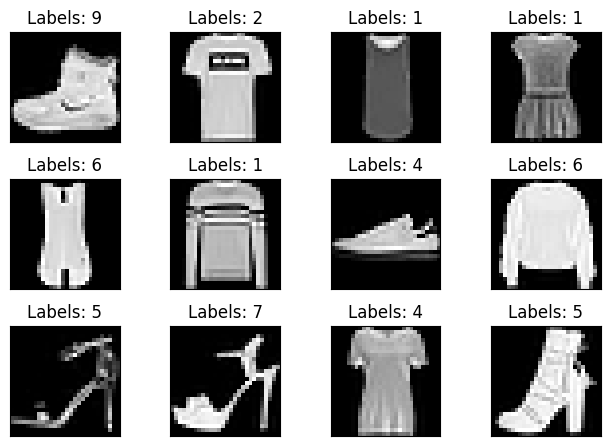

In [4]:
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.1307,), (0.3081,))
                                ])


fmnist_train = torchvision.datasets.FashionMNIST(
    root="../Data/FMNIST", train=True, transform=transform, download=True
)

fmnist_test = torchvision.datasets.FashionMNIST(
    root="../Data/FMNIST", train=False, transform=transform, download=True
)


#fig = plt.figure()
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.tight_layout() # 自动调整子图参数，以使图像和标题不重叠，并使布局更紧凑
    plt.imshow(fmnist_train.data[i], cmap='gray', interpolation='none')
    plt.title("Labels: {}".format(fmnist_test.targets[i]))
    plt.xticks([]) # 隐藏 x 轴和 y 轴的刻度，以便图像显示更整洁
    plt.yticks([])
plt.show()

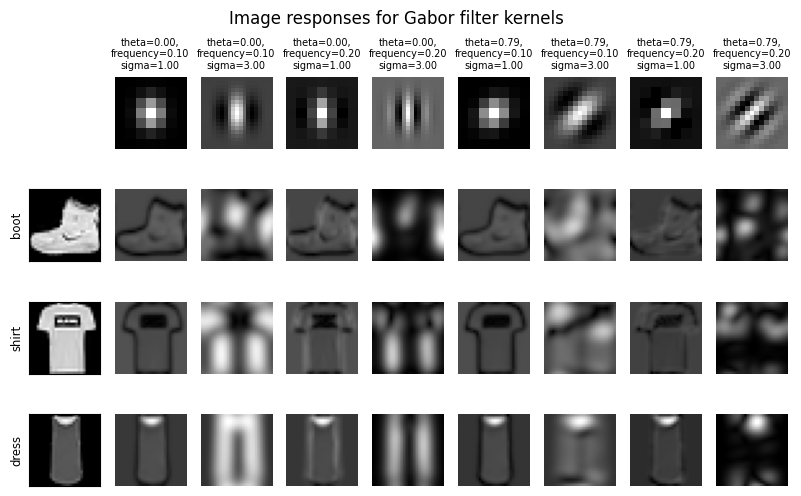

In [5]:
boot = fmnist_train[0][0].numpy().squeeze().reshape(28,28)
shirt = fmnist_train[1][0].numpy().squeeze().reshape(28,28)
dress = fmnist_train[2][0].numpy().squeeze().reshape(28,28)
image_names = ('boot', 'shirt', 'dress')
images = (boot, shirt, dress)


def magnitude(image, kernel):
    """ 
    计算 Gabor 滤波器对输入图像的响应幅度:
    该函数通过对图像进行归一化和卷积操作，最终返回 Gabor 滤波器对图像的响应幅度，
    常用于边缘检测和纹理分析等图像处理任务
    """
    image = (image - image.mean()) / image.std() # Normalize images
    return np.sqrt(ndi.convolve(image, np.real(kernel), mode='wrap')**2 +
                   ndi.convolve(image, np.imag(kernel), mode='wrap')**2)

def plot_filter_bank(images, fig_scale = 0.7):
    # Create a set of kernels, apply them to each image, store the results
    results = []
    kernel_params = []
    for theta in (0, 1):
        theta = theta / 4. * np.pi
        for frequency in (0.1, 0.2):
            for sigma in (1, 3):
                kernel = gabor_kernel(frequency, theta=theta,sigma_x=sigma,sigma_y=sigma)
                params = 'theta=%.2f,\nfrequency=%.2f\nsigma=%.2f' % (theta, frequency, sigma)
                kernel_params.append(params)
                results.append((kernel, [magnitude(img, kernel) for img in images]))

    # Plotting
    fig, axes = plt.subplots(nrows=4, ncols=9, figsize=(14*fig_scale, 8*fig_scale))
    plt.gray()
    fig.suptitle('Image responses for Gabor filter kernels', fontsize=12)
    axes[0][0].axis('off') # 使第一个子图不显示坐标轴

    for label, img, ax in zip(image_names, images, axes[1:]):
        axs = ax[0]
        axs.imshow(img)
        axs.set_ylabel(label, fontsize=12*fig_scale)
        axs.set_xticks([]) # Remove axis ticks 
        axs.set_yticks([])
        
    # Plot Gabor kernel
    col = 1
    for label, (kernel, magnitudes), ax_col in zip(kernel_params, results, axes[0][1:]):
        ax_col.imshow(np.real(kernel), interpolation='nearest') # Plot kernel
        ax_col.set_title(label, fontsize=10*fig_scale)
        ax_col.axis('off')
        
        # Plot Gabor responses with the contrast normalized for each filter
        vmin = np.min(magnitudes)
        vmax = np.max(magnitudes)
        for patch, ax in zip(magnitudes, axes.T[col][1:]):
            ax.imshow(patch, vmin=vmin, vmax=vmax) # Plot convolutions
            ax.axis('off')
        col += 1
    
    plt.show()

plot_filter_bank(images)

## 2. ConvNets

Finding relationships between **individual pixels** and the **correct class** is hard; <p>

---> **Simplify** the problem by decomposing it into **smaller problems**:

- First, discover 'local' patterns (edges, lines, endpoints)

- Representing such local patterns as features makes it easier to learn from them

    - **Deeper** layers will do that for us

    - We could use convolutions, but how to **choose the filters**?


Instead of manually designing the filters, we can also ***learn*** them based on data:

- **Choose filter sizes (manually), initialize with small random weights**

- **Forward pass**: Convolutional layer slides the filter over the input, generates the output

- **Backward pass**: Update the filter weights according to the loss gradients

### 2.1 Feature Maps

在每个卷积层, 数据都是以三维形式存在的. 你可以把它看成许多个二维图片叠在一起, 其中每一个称为一个`feature map`. 在输入层, 如果是灰度图片, 那就只有一个feature map; 如果是彩色图片, 一般就是3个`feature map``(红绿蓝)`. 层与层之间会有若干个卷积核(kernel), 上一层的`feature maps`跟每个卷积核做卷积, 都会产生下一层的一个`feature map`. (**注意:** 如果上一层有多个`feature map`, 即输入数据是三维的, 那么卷积的大小也是三维的)

- **特征图个数=输出通道数=卷积核个数**

- 一般网络越深, 这一层的`feature map`的数量越多. 因为随着网络的加深, `feature map`的长宽尺寸缩小, 本卷积层的每个`map`提取的特征越具有代表性(精华部分), 所以后一层卷积层需要增加`feature map`的数量, 才能更充分的提取出前一层的特征, 一般是**成倍增加(不过具体论文会根据实验情况具体设置)**


- **Example**: 对于`nn.Conv2d(10, 20, kernel_size=5)`, 假设输入数据的形状为 `(N, 10, H, W)`, 其中: N: 批量大小(batch size) ; 10: 输入通道数; H: 输入特征图的高度; W: 输入特征图的宽度. 那么卷积核的形状为 `(20, 10, 5, 5)`(相当于20个作用于三维数据上的卷积).

### 2.2. Receptive field (感受野)

**感受野(Receptive Field)** 是指卷积神经网络中特定神经元能够"看到"的输入区域. 具体来说, 它描述了**输入数据**中的哪些部分会影响到该神经元的输出.

- Maxpooling doubles the receptive field without deepening the network

### 2.3. 全局平均池化(Global Average Pooling)

- **定义:** 将特征图所有像素值相加求平局, 得到一个数值, 即用该数值表示对应特征图.

- **目的:** 替代全连接层/`nn.Flatten()`

- **效果:** 减少参数数量, 减少计算量, 减少过拟合.

- **思路:** 假设最终分成5类, 则最后卷积层应该包含5个滤波器(即输出5个特征图), 然后按照全局池化平均定义, 分别对每个特征图, 累加所有像素值并求平均, 最后得到5个数值, 将这5个数值输入到`softmax`层中, 得到5个概率值, 即`input`属于每个类别的概率值.

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/09_GAP.png?raw=1" alt="ml" style="width: 70%;  margin-left: auto; margin-right: auto;"/>

- Use with caution: this destroys the **location information** learned by the CNN

- Not ideal for tasks such as object localization

## 3. CNN in practice
### 3.1. `torchinfo`

- Observe how the input image on `1x28x28` is transformed to a `64x3x3` feature map 
    - In pytorch, shapes are `(batch_size, channels, height, width)`
- Conv2d parameters in `torchinfo`= (kernel size^2 × input channels + 1) × output channels
- After every MaxPooling, resolution halved in every dimension

In [6]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=0),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=0),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(64 * 3 * 3, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
)


from torchinfo import summary
summary(model, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─ReLU: 1-2                              [1, 32, 26, 26]           --
├─MaxPool2d: 1-3                         [1, 32, 13, 13]           --
├─Conv2d: 1-4                            [1, 64, 11, 11]           18,496
├─ReLU: 1-5                              [1, 64, 11, 11]           --
├─MaxPool2d: 1-6                         [1, 64, 5, 5]             --
├─Conv2d: 1-7                            [1, 64, 3, 3]             36,928
├─ReLU: 1-8                              [1, 64, 3, 3]             --
├─Flatten: 1-9                           [1, 576]                  --
├─Linear: 1-10                           [1, 64]                   36,928
├─ReLU: 1-11                             [1, 64]                   --
├─Linear: 1-12                           [1, 10]                   650
T

In [7]:
# using global average pooling

model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=0),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=0),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),  # Global Average Pooling (GAP)
    nn.Flatten(),  # Convert (batch, 64, 1, 1) -> (batch, 64)
    nn.Linear(64, 10)  # Output layer for 10 classes
)
summary(model, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─ReLU: 1-2                              [1, 32, 26, 26]           --
├─MaxPool2d: 1-3                         [1, 32, 13, 13]           --
├─Conv2d: 1-4                            [1, 64, 11, 11]           18,496
├─ReLU: 1-5                              [1, 64, 11, 11]           --
├─MaxPool2d: 1-6                         [1, 64, 5, 5]             --
├─Conv2d: 1-7                            [1, 64, 3, 3]             36,928
├─ReLU: 1-8                              [1, 64, 3, 3]             --
├─AdaptiveAvgPool2d: 1-9                 [1, 64, 1, 1]             --
├─Flatten: 1-10                          [1, 64]                   --
├─Linear: 1-11                           [1, 10]                   650
Total params: 56,394
Trainable params: 56,394
Non-trainable params: 0
Total

### 3.2. CNN in `pytorch_lightning` for FashionMNIST

In [9]:
# Keeps a history of scores to make plotting easier
class MetricTracker(pl.Callback):
    def __init__(self):
        super().__init__()
        
        # 初始化一个字典来存储训练和验证的损失与准确率
        self.history = {
            "train_loss": [],
            "train_acc": [],
            "val_loss": [],
            "val_acc": []
        }
        self.first_validation = True  # Flag to ignore first validation step

    def on_train_epoch_end(self, trainer, pl_module):
        """Collects training metrics at the end of each epoch"""
        train_loss = trainer.callback_metrics.get("train_loss")
        train_acc = trainer.callback_metrics.get("train_acc")
        if train_loss is not None:
            # 使用 cpu().item() 将张量转为 Python 标量
            self.history["train_loss"].append(train_loss.cpu().item())
        if train_acc is not None:
            self.history["train_acc"].append(train_acc.cpu().item())

    def on_validation_epoch_end(self, trainer, pl_module):
        """Collects validation metrics at the end of each epoch"""
        if self.first_validation:  
            self.first_validation = False  # Skip first validation logging
            return  

        val_loss = trainer.callback_metrics.get("val_loss")
        val_acc = trainer.callback_metrics.get("val_acc")

        if val_loss is not None:
            self.history["val_loss"].append(val_loss.cpu().item())
        if val_acc is not None:
            self.history["val_acc"].append(val_acc.cpu().item())
            
def plot_training(history):
    """ 
    绘制两张子图: Loss vs Epochs 以及 Accuracy vs Epochs
    """
    plt.figure(figsize=(12, 4))  # Increased figure size

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss", marker='o', lw=2)
    plt.plot(history["val_loss"], label="Validation Loss", marker='o', lw=2)
    plt.xlabel("Epochs", fontsize=14)  # Larger font size
    plt.ylabel("Loss", fontsize=14)
    plt.title("Loss vs. Epochs", fontsize=16, fontweight="bold")
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Train Accuracy", marker='o', lw=2)
    plt.plot(history["val_acc"], label="Validation Accuracy", marker='o', lw=2)
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("Accuracy", fontsize=14)
    plt.title("Accuracy vs. Epochs", fontsize=16, fontweight="bold")
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)

    plt.tight_layout()  # Adjust layout for readability
    plt.show()

In [11]:
# Model in Pytorch Lightning
class MNISTModel(pl.LightningModule):
    def __init__(self, learning_rate=0.001):
        super().__init__()
        self.save_hyperparameters()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 64, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(64, 10)
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.layers(x)

    # Logging of loss and accuracy for later plotting
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = accuracy(logits, y, task="multiclass", num_classes=10)
        self.log("train_loss", loss, prog_bar=True, on_epoch=True)
        self.log("train_acc", acc, prog_bar=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = accuracy(logits, y, task="multiclass", num_classes=10)
        # 参数 prog_bar=True 表示在训练进度条上显示这些值，on_epoch=True 表示这些值将在每个 epoch 的结束时被记录
        self.log("val_loss", loss, prog_bar=True, on_epoch=True)
        self.log("val_acc", acc, prog_bar=True, on_epoch=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = accuracy(logits, y, task="multiclass", num_classes=10)
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", acc, prog_bar=True)
        return loss

    def on_train_epoch_end(self):
        """ 
        self.trainer: 这是指当前模型的训练器(rainer) 对象, 负责管理训练过程, 包括训练,验证和测试
        self.trainer.callback_metrics: 这是一个字典, 包含在训练过程中收集的各种指标. 这些指标通常由回调函数(callbacks)更新, 并可以在训练期间访问
        """
        avg_loss = self.trainer.callback_metrics["train_loss"].item()
        avg_acc = self.trainer.callback_metrics["train_acc"].item()
        # print(f"Average training loss on epoch {self.trainer.current_epoch+1}: Loss = {avg_loss:.4f}, Accuracy = {avg_acc:.4f}")
    
    def on_validation_epoch_end(self):
        avg_loss = self.trainer.callback_metrics["val_loss"].item()
        avg_acc = self.trainer.callback_metrics["val_acc"].item()
        #print(f"Average validation loss on epoch {self.trainer.current_epoch+1}: Loss = {avg_loss:.4f}, Accuracy = {avg_acc:.4f}")

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.hparams.learning_rate)

# Compute mean and std to normalize the data
# Couldn't find a way to do this automatically in PyTorch :(
# Normalization is not strictly needed, but speeds up convergence
dataset = datasets.FashionMNIST(root="../Data/FMNIST", train=True, transform=transforms.ToTensor(), download=True)
loader = torch.utils.data.DataLoader(dataset, batch_size=1000, num_workers=2, shuffle=False, persistent_workers=True)
mean = torch.mean(torch.stack([batch[0].mean() for batch in loader]))
std = torch.mean(torch.stack([batch[0].std() for batch in loader]))

class MNISTDataModule(pl.LightningDataModule):
    """ 
    用于管理数据加载和预处理的模块
    """
    def __init__(self, batch_size=64):
        super().__init__()
        self.batch_size = batch_size
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((mean,), (std,))  # Normalize FashionMNIST. Make more general?
        ])

    def prepare_data(self):
        datasets.FashionMNIST(root="../Data/FMNIST", train=True, download=True)  # Downloads dataset

    def setup(self, stage=None):
        full_train = datasets.FashionMNIST(root="../Data/FMNIST", train=True, transform=self.transform)
        self.train, self.val = random_split(full_train, [55000, 5000])
        self.test = datasets.FashionMNIST(root="../Data/FMNIST", train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.batch_size, shuffle=True, num_workers=2, persistent_workers=True)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=self.batch_size, num_workers=2, persistent_workers=True)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=self.batch_size, num_workers=2, persistent_workers=True)

    
# Initialize data & model
pl.seed_everything(42)  # Ensure reproducibility
data_module = MNISTDataModule(batch_size=64)
model = MNISTModel(learning_rate=0.001)

# Trainer with logging & checkpointing
accelerator = "cpu"
if torch.backends.mps.is_available():
    accelerator = "mps"
if torch.cuda.is_available():
    accelerator = "gpu"

metric_tracker = MetricTracker()  # Callback to track per-epoch metrics

trainer = pl.Trainer(
    max_epochs=10,  # Train for 10 epochs
    accelerator=accelerator,
    devices="auto",
    log_every_n_steps=10,
    deterministic=True,
    callbacks=[metric_tracker]  # Attach callback to trainer
)


trainer.fit(model, datamodule=data_module)
history = metric_tracker.history

# Test after training (sanity check)
# 必须要在模型中定义test_step()才能使用
trainer.test(model, datamodule=data_module)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | layers  | Sequential       | 56.4 K
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
56.4 K    Trainable params
0         Non-trainable params
56.4 K    Total params
0.226     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 860/860 [00:05<00:00, 144.62it/s, v_num=2, train_loss_step=0.392, train_acc_step=0.792, val_loss=0.265, val_acc=0.902, train_loss_epoch=0.254, train_acc_epoch=0.907] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 860/860 [00:05<00:00, 144.43it/s, v_num=2, train_loss_step=0.392, train_acc_step=0.792, val_loss=0.265, val_acc=0.902, train_loss_epoch=0.254, train_acc_epoch=0.907]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:00<00:00, 187.16it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8895000219345093
        test_loss           0.30125975608825684
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.30125975608825684, 'test_acc': 0.8895000219345093}]

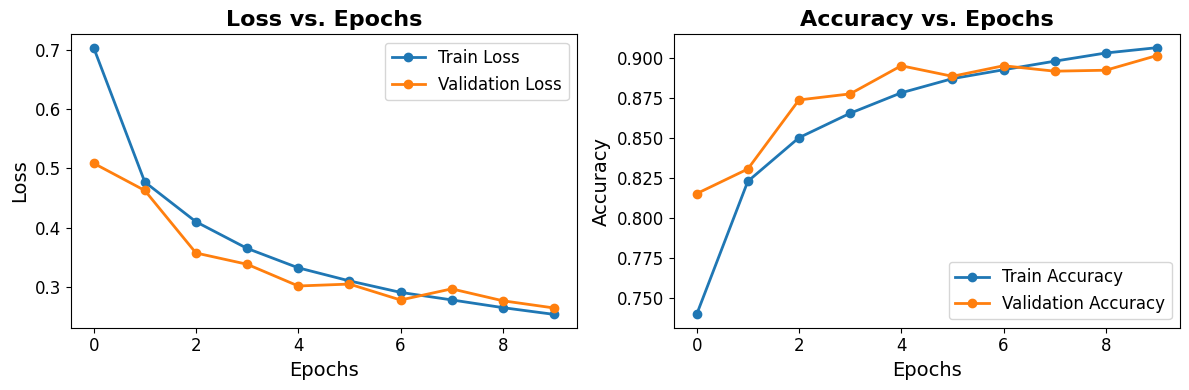

In [12]:
plot_training(history)

### 3.3. CNN in `pytorch_lightning` for a more realistic dataset

- A more realistic dataset: [Cats vs Dogs](https://www.kaggle.com/c/dogs-vs-cats/data)
    - Colored JPEG images, **different sizes**
    - Not nicely centered, translation invariance is important
- **Preprocessing**
    - Decode JPEG images to floating-point tensors
    - Rescale pixel values to [0,1]
    - Resize images to 150x150 pixels

In [ ]:
""" 
下载猫狗大战的数据: https://www.kaggle.com/c/dogs-vs-cats/data
--- 将 `train.zip` 里的所有图片解压到 `original_dataset_dir` 路径下
--- 选择`original_dataset_dir`的一部分图片, 建立 训练集 和 验证集, 并存放在 `data_dir` 路径下
"""

""" 
import os, shutil 
import random

original_dataset_dir = '../Data/cats-vs-dogs'
data_dir = '../Data/cats-vs-dogs_small'

# The directory where we will
# store our smaller dataset
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')

if not os.path.exists(data_dir):
    os.mkdir(data_dir)
    os.mkdir(train_dir)
    os.mkdir(validation_dir)
    
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

if not os.path.exists(train_cats_dir):
    os.mkdir(train_cats_dir)
    os.mkdir(train_dogs_dir)
    os.mkdir(validation_cats_dir)
    os.mkdir(validation_dogs_dir)

# Copy first 2000 cat images to train_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 1000 cat images to validation_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(2000, 3000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy first 2000 dog images to train_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 1000 dog images to validation_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(2000, 3000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
"""

#### 3.3.1 Data Preprocessing & Data Loading

We create a Pytorch Lightning `DataModule` to do preprocessing and data loading

Seed set to 42
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94509804..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8666667].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9372549..0.9607843].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8117647].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..0.6392157].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8117647].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0]

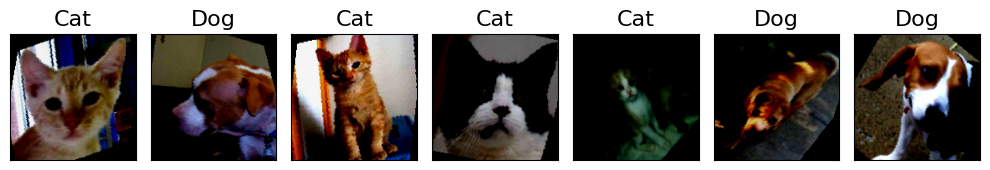

In [13]:
# Set random seed for reproducibility
def seed_everything(seed=42):

    """ 
    seed_everything 函数接受一个种子值, 并将其用于多个库(如PyTorch, NumPy)
    来确保每次运行代码时生成的随机数相同, 从而达到可重复的实验结果
    """
    pl.seed_everything(seed)  # Sets seed for PyTorch Lightning
    torch.manual_seed(seed)  # PyTorch
    torch.cuda.manual_seed_all(seed)  # CUDA (if available)
    np.random.seed(seed)  # NumPy
    random.seed(seed)  # Python random module
    torch.backends.cudnn.deterministic = True  # Ensures reproducibility in CNNs, cuda my not support
    torch.backends.cudnn.benchmark = False  # Ensures consistency, cuda my not support

seed_everything(42)  # Set global seed

class CatDataModule(pl.LightningDataModule):
    """ 
    加载和处理图像数据
    """
    def __init__(self, data_dir, batch_size=20, img_size=(150, 150)):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.img_size = img_size

        # Define image transformations
        self.transform = transforms.Compose([
            transforms.Resize(self.img_size),  # Resize to 150x150
            transforms.ToTensor(),  # Convert to tensor (also scales 0-1)
        ])

    def setup(self, stage=None):
        """Load datasets"""
        train_dir = os.path.join(self.data_dir, "train")
        val_dir = os.path.join(self.data_dir, "validation")

        self.train_dataset = datasets.ImageFolder(root=train_dir, transform=self.transform)
        self.val_dataset = datasets.ImageFolder(root=val_dir, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=2, persistent_workers=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=2, persistent_workers=True)
    
class AugmentCatDataModule(pl.LightningDataModule):
    """ 
    加载和处理图像数据
    使用了图像增强data augmentation
    """
    def __init__(self, data_dir, batch_size=20, img_size=(150, 150)):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.img_size = img_size

        # Training Data Augmentation 
        self.train_transform = transforms.Compose([
            transforms.Resize(self.img_size),
            transforms.RandomRotation(40),
            transforms.RandomResizedCrop(self.img_size, scale=(0.8, 1.2)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomAffine(degrees=0, shear=20),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

        # Test Data Transforms (NO augmentation, just resize + normalize)
        self.val_transform = transforms.Compose([
            transforms.Resize(self.img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

    def setup(self, stage=None):
        """Load datasets with correct transforms"""
        train_dir = os.path.join(self.data_dir, "train")
        val_dir = os.path.join(self.data_dir, "validation")

        # Apply augmentation only to training data
        self.train_dataset = datasets.ImageFolder(root=train_dir, transform=self.train_transform)
        self.val_dataset = datasets.ImageFolder(root=val_dir, transform=self.val_transform)

    def train_dataloader(self):
        """Applies augmentation via the pre-defined transform"""
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=2,persistent_workers=True)

    def val_dataloader(self):
        """Loads validation data WITHOUT augmentation"""
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=2,persistent_workers=True)

# ----------------------------
# Load dataset and visualize a batch
# ----------------------------
data_dir = '../Data/cats-vs-dogs_small'
data_module = AugmentCatDataModule(data_dir=data_dir)
data_module.setup()
train_loader = data_module.train_dataloader()

# Get a batch of data
data_batch, labels_batch = next(iter(train_loader))
# Visualize images
plt.figure(figsize=(10, 5))
for i in range(7):
    plt.subplot(1, 7, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(data_batch[i].permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    plt.title("Cat" if labels_batch[i] == 0 else "Dog", fontsize=16)
plt.tight_layout()
plt.show()

#### 3.3.2 Model Def --- `CatImageClassifier`

In [14]:
from torchmetrics.classification import Accuracy


# Model in PyTorch Lightning
class CatImageClassifier(pl.LightningModule):
    def __init__(self, learning_rate=0.001):
        super().__init__()
        self.save_hyperparameters()

        # Define convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 128, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.AdaptiveAvgPool2d(1)  # GAP replaces Flatten()
        )

        # Fully connected layers (FC) with Dropout
        self.fc_layers = nn.Sequential(
            nn.Linear(128, 512),  # GAP outputs (batch, 128, 1, 1) → Flatten to (batch, 128)
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout (same as Keras Dropout(0.5))
            nn.Linear(512, 1)  # Binary classification (1 output neuron)
        )

        self.loss_fn = nn.BCEWithLogitsLoss()
        self.accuracy = Accuracy(task="binary")

    def forward(self, x):
        x = self.conv_layers(x)  # Convolutions + GAP
        x = x.view(x.size(0), -1)  # Flatten from (batch, 128, 1, 1) → (batch, 128)
        x = self.fc_layers(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x).squeeze(1)  # Remove extra dimension
        loss = self.loss_fn(logits, y.float())  # BCE loss requires float labels

        preds = torch.sigmoid(logits)  # Convert logits to probabilities
        acc = self.accuracy(preds, y)

        self.log("train_loss", loss, prog_bar=True, on_epoch=True)
        self.log("train_acc", acc, prog_bar=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x).squeeze(1)
        loss = self.loss_fn(logits, y.float())

        preds = torch.sigmoid(logits)
        acc = self.accuracy(preds, y)

        self.log("val_loss", loss, prog_bar=True, on_epoch=True)
        self.log("val_acc", acc, prog_bar=True, on_epoch=True)

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.hparams.learning_rate, weight_decay=1e-4)
    
model = CatImageClassifier()
summary(model, input_size=(1, 3, 150, 150))

Layer (type:depth-idx)                   Output Shape              Param #
CatImageClassifier                       [1, 1]                    --
├─Sequential: 1-1                        [1, 128, 1, 1]            --
│    └─Conv2d: 2-1                       [1, 32, 148, 148]         896
│    └─ReLU: 2-2                         [1, 32, 148, 148]         --
│    └─MaxPool2d: 2-3                    [1, 32, 74, 74]           --
│    └─Conv2d: 2-4                       [1, 64, 72, 72]           18,496
│    └─ReLU: 2-5                         [1, 64, 72, 72]           --
│    └─MaxPool2d: 2-6                    [1, 64, 36, 36]           --
│    └─Conv2d: 2-7                       [1, 128, 34, 34]          73,856
│    └─ReLU: 2-8                         [1, 128, 34, 34]          --
│    └─MaxPool2d: 2-9                    [1, 128, 17, 17]          --
│    └─Conv2d: 2-10                      [1, 128, 15, 15]          147,584
│    └─ReLU: 2-11                        [1, 128, 15, 15]          --
│

#### 3.3.3  Training the model and save checkpoint

- dropout
- data auhmentation
- learning rate decay

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping
    
# Train Cat model
pl.seed_everything(42)  # Ensure reproducibility
data_module = AugmentCatDataModule(data_dir, batch_size=64)
model = CatImageClassifier(learning_rate=0.001)
metric_tracker = MetricTracker()  # Callback to track per-epoch metrics
from pytorch_lightning.callbacks import ModelCheckpoint

# Define checkpoint callback to save the best model
# EarlyStopping 将在后台监控 val_loss，每个 epoch 后自动判断是否需要停止训练
# patience=3 是容忍度的设置, 如果 val_loss 在连续 3 个 epoch 中没有下降，训练就会提前终止
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",  # Saves model with lowest validation loss
    mode="min",  # "min" for loss, "max" for accuracy
    save_top_k=1,  # Keep only the best model
    dirpath="./lightning_logs/model_checkpoints/",  # Directory to save checkpoints
    filename="cat_model",  # File name pattern
)

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor="val_loss",     # 监控的是验证集的损失（val_loss）
    mode="min",             # 希望它尽可能小（minimize）
    patience=3              # 容忍3个epoch没有提升，就停止训练
)

"""
# 启用了PyTorch 的确定性算法(deterministic behavior), PyTorch 会强制所有操作必须是可复现的.
# 但是操作(如 F.linear)在 CUDA ≥ 10.2 的环境下是非确定性的(non-deterministic), 因为它依赖于 CuBLAS 库
# 如果坚持启用确定性, 必须设置一个环境变量:
```python
# 在导入任何 PyTorch 模块并初始化 GPU 之前设置, 否则不会生效.
# 建议写在脚本最开始
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

```
# 或者 不强制使用 deterministic 算法

trainer = pl.Trainer(
    max_epochs=10,  # Train for 10 epochs
    accelerator=accelerator,
    devices="auto",
    log_every_n_steps=10,
    callbacks=[metric_tracker, checkpoint_callback]  # Attach callback to trainer
)

"""
trainer = pl.Trainer(
    max_epochs=50,  # Train for 10 epochs
    accelerator=accelerator,
    devices="auto",
    log_every_n_steps=10,
    deterministic=True,
    callbacks=[metric_tracker, checkpoint_callback, early_stopping]  # Attach callback to trainer
)

histories = {}

# If previously trained, load history and weights
if histories and histories["cat"]:
    history_cat = histories["cat"]
    model = CatImageClassifier.load_from_checkpoint("./lightning_logs/model_checkpoints/cat_model.ckpt")
else:
    trainer.fit(model, datamodule=data_module)
    history_cat = metric_tracker.history
    histories['cat'] = history_cat
    
# Set to evaluation mode so we don't update the weights
model.eval()

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type              | Params
--------------------------------------------------
0 | conv_layers | Sequential        | 240 K 
1 | fc_layers   | Sequential        | 66.6 K
2 | loss_fn     | BCEWithLogitsLoss | 0     
3 | accuracy    | BinaryAccuracy    | 0     
--------------------------------------------------
307 K     Trainable params
0         Non-trainable params
307 K     Total params
1.230     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 63/63 [00:08<00:00,  7.18it/s, v_num=1, train_loss_step=0.464, train_acc_step=0.750, val_loss=0.507, val_acc=0.742, train_loss_epoch=0.478, train_acc_epoch=0.772]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 63/63 [00:08<00:00,  7.18it/s, v_num=1, train_loss_step=0.464, train_acc_step=0.750, val_loss=0.507, val_acc=0.742, train_loss_epoch=0.478, train_acc_epoch=0.772]


CatImageClassifier(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): AdaptiveAvgPool2d(output_size=1)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=1, bias=True)
  )
  (loss_fn): BCEWithLogitsLoss()
  (accuracy): BinaryAcc

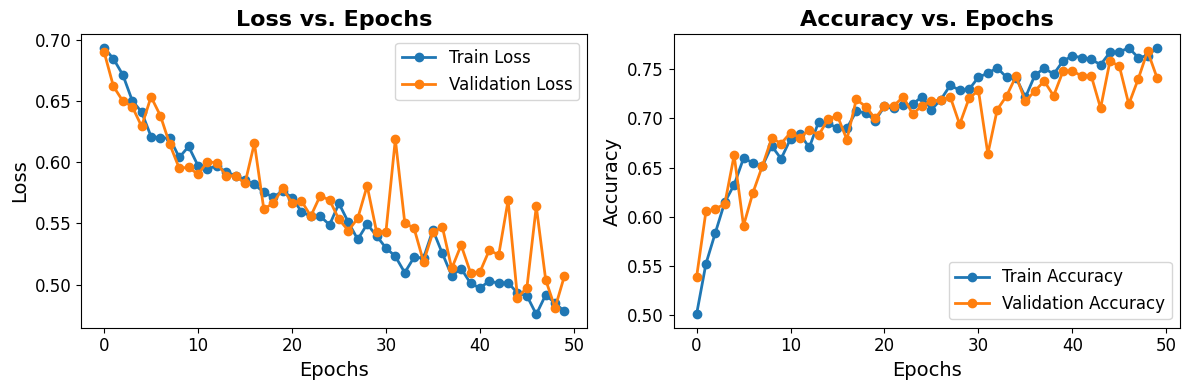

In [18]:
plot_training(history_cat)

## 4. Data augmentation 图像增强

- 在训练阶段对图像进行一系列预处理和随机变换, 从而提升模型的泛化能力

* Generate new images via image transformations (only on training data!)
    - Images will be randomly transformed _every epoch_
* Update the transform in the data module

- 具体代码见 3.3.1 `class AugmentCatDataModule(pl.LightningDataModule):`

## 5. Real-world CNNs
### 5.1 VGG16
* Deeper architecture (16 layers): allows it to learn more complex high-level features
    * Textures, patterns, shapes,...
* Small filters (3x3) work better: capture spatial information while reducing number of parameters
* Max-pooling (2x2): reduces spatial dimension, improves translation invariance
    * Lower resolution forces model to learn robust features (less sensitive to small input changes)
    * Only after every 2 layers, otherwise dimensions reduce too fast
* Downside: too many parameters, expensive to train
    
<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/09_vgg16.png?raw=1" alt="ml" style="width: 70%;  margin-left: auto; margin-right: auto;"/>

### 5.2. Inceptionv3
* Inception modules: parallel branches learn features of different sizes and scales (3x3, 5x5, 7x7,...)
    * Add reduction blocks that reduce dimensionality via convolutions with stride 2
* Factorized convolutions: a 3x3 conv. can be replaced by combining 1x3 and 3x1, and is 33% cheaper
    * A 5x5 can be replaced by combining 3x3 and 3x3, which can in turn be factorized as above
* 1x1 convolutions, or Network-In-Network (NIN) layers help reduce the number of channels: cheaper
* An auxiliary classifier adds an additional gradient signal deeper in the network
    
<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/09_inception.png?raw=1" alt="ml" style="width: 80%;  margin-left: auto; margin-right: auto;"/>

#### 5.2.1 Factorized convolutions
* A 3x3 conv. can be replaced by combining 1x3 and 3x1, and is 33% cheaper
    
<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/factorized_convolutions.jpg?raw=1" alt="ml" style="width: 80%;  margin-left: auto; margin-right: auto;"/>

### 5.3. ResNet50
* Residual (skip) connections: add earlier feature map to a later one (dimensions must match)
    * Information can bypass layers, reduces vanishing gradients, allows much deeper nets
* Residual blocks: skip small number or layers and repeat many times
    * Match dimensions though padding and 1x1 convolutions
    * When resolution drops, add 1x1 convolutions with stride 2
* Can be combined with Inception blocks
    
<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/09_resnet50.png?raw=1" alt="ml" style="width: 90%;  margin-left: auto; margin-right: auto;"/>

## 6. Interpreting the model

### 6.1. 可视化神经网络中间层输出

- 让我们通过观察 **中间特征图(feature maps)** 来看看卷积神经网络到底学到了什么.

- 我们可以很容易地通过给某一层添加一个"**钩子(hook)**" (`def hook_fn()`),从而读取该层的输出(即激活值)

In [19]:
from PIL import Image

seed_everything(42)

def load_image(img_path, img_size=(150, 150)):
    """Load and preprocess a specific image as a PyTorch tensor."""
    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),  # Converts image to tensor with values in [0,1]
    ])
    
    img = Image.open(img_path).convert("RGB")  # Ensure RGB format
    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension
    return img_tensor

def get_layer_activations(model, img_tensor, layer_idx=0, keep_gradients=False):
    """-------------Extract activations from a specific layer------------------
    input para:
        model: 要分析的神经网络模型(例如 CatImageClassifier)

        img_tensor: 输入图片, 形状如 [1, 3, 150, 150]

        layer_idx: 你想提取哪一层的激活(默认是第 0 层)

        keep_gradients: 是否保留梯度信息(一般用于可视化或生成对抗样本)
    return:
        activation value at layer_idx layer
    """
    activation = None
    
    def hook_fn(module, input, output):
        """ --------hook_fn 是一个"钩子函数", 在 forward 时被调用------------
        
        通过 register_forward_hook(), 把这个函数挂到了目标层上.
        当模型前向传播走到这个层时, output(该层的激活)会被捕获并存入 activation
        
        """
        nonlocal activation
        if keep_gradients: # Only for gradient ascent (later)
            activation = output
        else:
            activation = output.detach() # # 去掉梯度图, 仅用于查看数值

    # Register hook to capture the activation
    # 上面的 CatImageClassifier(pl.LightningModule) 模型定义了 self.conv_layers = nn.Sequential(...)
    # 对于其他模型如VGG, 也可以处理
    layer = model.conv_layers[layer_idx] if hasattr(model, "conv_layers") else model[layer_idx]
    hook = layer.register_forward_hook(hook_fn)    
    
    if keep_gradients:
        model(img_tensor)  # Run the image through the model
    else:
        with torch.no_grad():
            model(img_tensor)  # Idem but no grad
    
    hook.remove()  # Remove the hook after getting activations
    return activation

def visualize_activations(model, img_tensor, layer_idx=0, filter_idx=0):
    """Visualize input image and activations of a selected filter in a selected filiter."""

    # Get activations from the specified layer
    activations = get_layer_activations(model, img_tensor, layer_idx)

    # Convert activations to numpy for visualization
    activation_np = activations.squeeze(0).cpu().numpy()  # Remove batch dim
    
    # Show input image
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4, 2))
    
    # Convert input tensor to NumPy
    img_np = img_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()  # (H, W, C)
    img_np = np.clip(img_np, 0, 1)  # Ensure values are in range [0,1]
    
    ax1.imshow(img_np)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_xlabel("Input Image", fontsize=8)
    
    # Visualize a specific filter's activation
    ax2.imshow(activation_np[filter_idx], cmap="viridis")
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_xlabel(f"Activation of Filter {filter_idx}", fontsize=8)
    
    plt.tight_layout()
    plt.show()

Seed set to 42


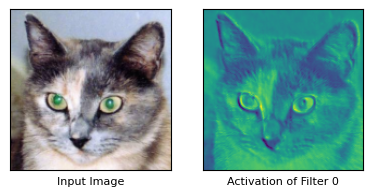

In [20]:
# ----------------------------
# # Load model and visualize activations
# ----------------------------

cat_model = CatImageClassifier.load_from_checkpoint("./lightning_logs/model_checkpoints/cat_model.ckpt")
device = next(cat_model.parameters()).device
img_path = os.path.join(data_dir, "train/cats/cat.1700.jpg")  # Test img's path
img_tensor = load_image(img_path).to(device)
visualize_activations(cat_model, img_tensor, layer_idx=0, filter_idx=0)

The same filter will highlight the same patterns in other inputs.

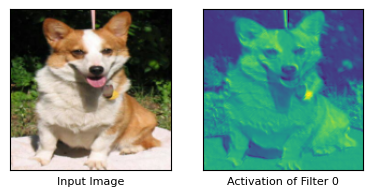

In [21]:
img_path_dog = os.path.join(data_dir, "train/dogs/dog.1528.jpg")
img_tensor_dog = load_image(img_path_dog).to(device)
visualize_activations(cat_model, img_tensor_dog, layer_idx=0, filter_idx=0)

In [23]:
def visualize_all_filters(model, img_tensor, layer_idx=0, max_per_row=16):
    """Visualize all filters of a given layer as a grid of feature maps."""
    activations = get_layer_activations(model, img_tensor, layer_idx)
    activation_np = activations.squeeze(0).cpu().numpy()
    
    num_filters = activation_np.shape[0]
    num_cols = min(num_filters, max_per_row)
    num_rows = (num_filters + num_cols - 1) // num_cols  # Ceiling division
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols, num_rows))
    axes = np.array(axes).reshape(num_rows, num_cols)  # Ensure it's a 2D array
    
    for i in range(num_rows * num_cols):
        ax = axes[i // num_cols, i % num_cols]
        
        if i < num_filters:
            ax.imshow(activation_np[i], cmap="viridis")
        
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.suptitle(f"All Filiters' Activations Output of Layer {layer_idx}", fontsize=16, y=1.0)
    plt.tight_layout()
    plt.show()

- 从下图我们可以看出随着网络深度的增加, 每个卷积提取到的特征越来越抽象, 比如第0层明显是整体, 而第6层则是局部特征如 耳朵, 鼻子, 眼睛

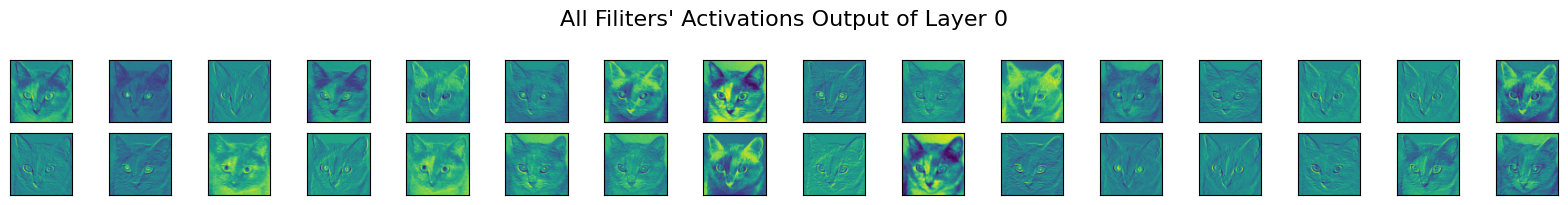

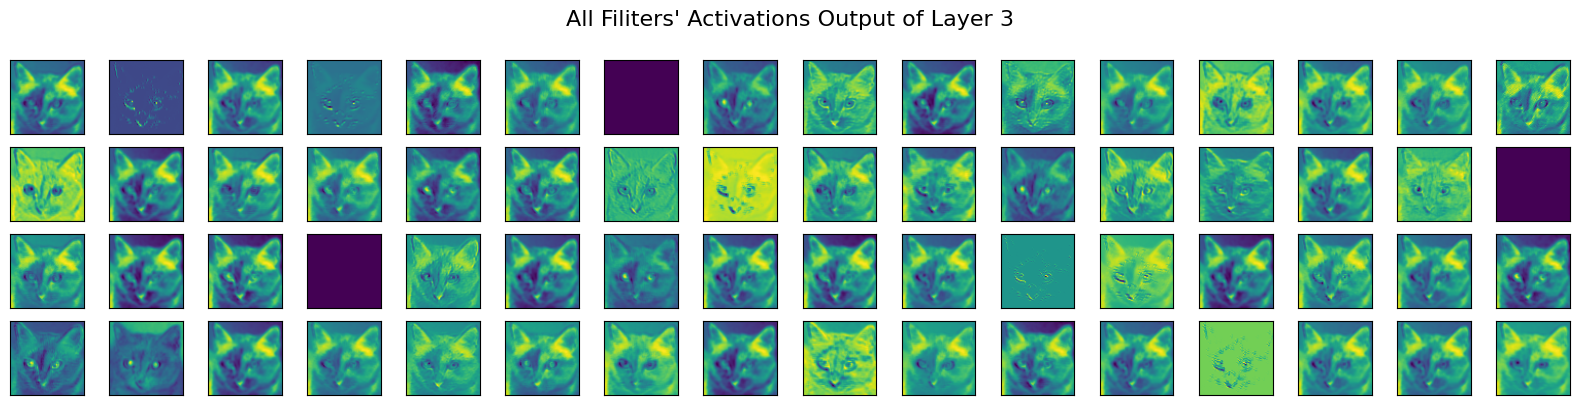

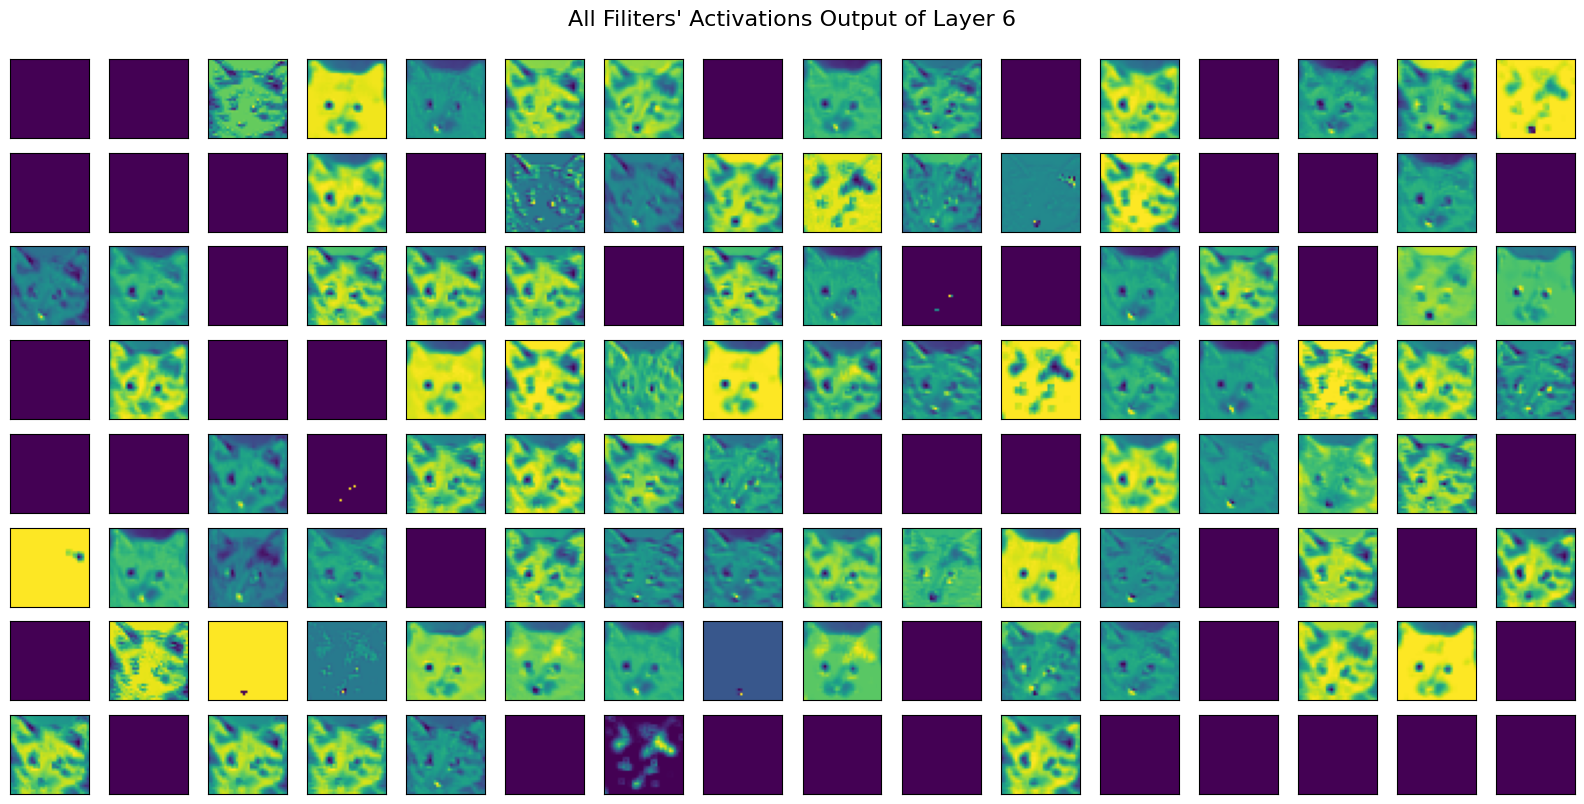

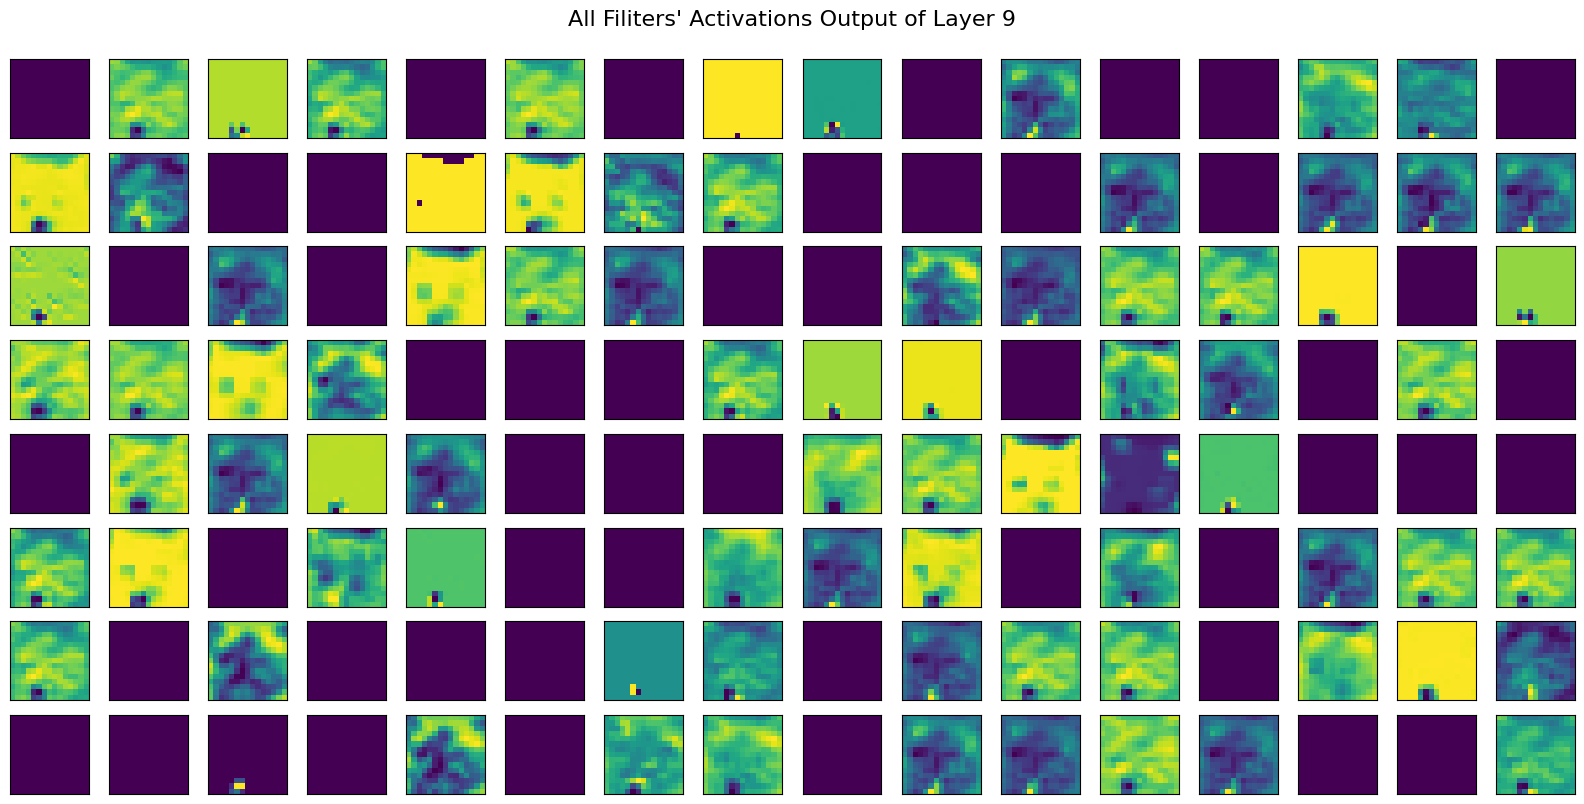

In [24]:
visualize_all_filters(cat_model, img_tensor, layer_idx=0)
visualize_all_filters(cat_model, img_tensor, layer_idx=3)
visualize_all_filters(cat_model, img_tensor, layer_idx=6)
visualize_all_filters(cat_model, img_tensor, layer_idx=9)

### 6.2. Spatial hierarchies
- Deep convnets can learn **spatial hierarchies (空间层次)** of patterns
    - First layer can learn very local patterns (e.g. edges)
    - Second layer can learn specific combinations of patterns
    - Every layer can learn increasingly complex ***abstractions***
    
<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/10_hierarchy.png?raw=1" alt="ml" style="width: 500px;  margin-left: auto; margin-right: auto;"/>

### 6.3. Visualizing the learned filters
**目的:** 可视化 CNN 某个卷积核(filter)到底在“关注”什么样的输入特征 <p>
**方法:** *Gradient Ascent in Input Space* ---- 不是去修改模型, 而是从一个随机图片出发, 通过优化这张图, 让它"激活"某个 filter <p>

**步骤分解:**
- 初始化输入图像 $X$: 通常是随机噪声图像(形状要和模型输入一致). 

- 选择一个 filter(比如某一层的第 3 个卷积核), 我们想让这个 filter 的输出最大化. 

- 前向传播: 计算图像 $X$ 通过网络后, 该 filter 的激活值 $A$. 

- 定义 loss 函数: 令 loss $L(X) = mean(A)$，也就是该 filter 输出的平均激活值

- 更新 $X$ : $X_{(i+1)} = X_{(i)} + \frac{\partial L(X_{(i)})}{\partial X} * \eta$

**从下面的实验结可以看出, 越深层的卷积核感兴趣的特征越复杂**

In [26]:
import cv2

class FilterVisualizer():
    def __init__(self, model, size=56, upscaling_steps=12, upscaling_factor=1.2, device=None):
        self.size = size
        self.upscaling_steps = upscaling_steps
        self.upscaling_factor = upscaling_factor
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = model.features if hasattr(model, 'features') else model
        self.model = self.model.to(self.device).eval()
        self.hook = None
        self.activations = None

        # Get indices of all Conv2d layers
        self.conv_layers = [layer for layer in self.model.modules() if isinstance(layer, nn.Conv2d)]

    def hook_fn(self, module, input, output):
        self.activations = output

    def register_hook(self, conv_layer_index):
        if self.hook is not None:
            self.hook.remove()
        layer = self.conv_layers[conv_layer_index]
        self.hook = layer.register_forward_hook(self.hook_fn)

    def visualize(self, conv_layer_index, filter_idx, lr=0.1, opt_steps=20, blur=None):
        sz = self.size
        img = np.random.uniform(150, 180, (sz, sz, 3)) / 255  # Random noise image

        self.register_hook(conv_layer_index)  # Attach hook

        for _ in range(self.upscaling_steps):  # Iteratively upscale
            img_tensor = torch.from_numpy(img.transpose(2, 0, 1)).unsqueeze(0).float().to(self.device)
            img_tensor.requires_grad_()
            optimizer = optim.Adam([img_tensor], lr=lr, weight_decay=1e-6)

            for _ in range(opt_steps):  # Optimize pixel values
                optimizer.zero_grad()
                self.model(img_tensor)
                loss = -self.activations[0, filter_idx].mean()
                loss.backward()
                optimizer.step()

            img = img_tensor.detach().cpu().numpy()[0].transpose(1, 2, 0)
            self.output = img
            sz = int(self.upscaling_factor * sz)  # Increase image size
            img = cv2.resize(img, (sz, sz), interpolation=cv2.INTER_CUBIC)  # Upscale image
            if blur is not None:
                img = cv2.GaussianBlur(img, (blur, blur), 0)  # Apply blur to reduce noise

        self.hook.remove()  # Remove hook after use
        return self.output

    def visualize_filters(self, conv_layer_index, num_filters=None, blur=None, filters=None):
        filter_images = []

        if filters:
            for filter_idx in filters:
                img = self.visualize(conv_layer_index, filter_idx, blur=blur)
                filter_images.append(img)
            num_filters = len(filters)
        else:
            # Visualize first to get activations and number of filters
            img = self.visualize(conv_layer_index, 0, blur=blur)
            filter_images.append(img)
            if self.activations is not None:
                total_filters = self.activations.shape[1]
                num_filters = num_filters or total_filters
                for filter_idx in range(1, num_filters):
                    img = self.visualize(conv_layer_index, filter_idx, blur=blur)
                    filter_images.append(img)
            else:
                raise RuntimeError("Failed to get layer activations.")

        self.show_filters(filter_images, num_filters, conv_layer_index)

    def show_filters(self, filter_images, num_filters, layer_id):
        cols = min(10, num_filters)  # Limit to max 10 columns
        rows = (num_filters // cols) + int(num_filters % cols > 0)

        fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
        axes = np.array(axes).flatten()  # Flatten in case of single row/col

        for i, img in enumerate(filter_images):
            axes[i].imshow(np.clip(img, 0, 1))
            axes[i].axis('off')

        # Remove empty subplots
        for i in range(len(filter_images), len(axes)):
            fig.delaxes(axes[i])

        fig.subplots_adjust(wspace=0, hspace=0)
        plt.tight_layout(pad=0, rect=[0.05, 0, 1, 1])  # Leave room on the left (x=0.05)
        fig.supylabel(f"Layer {layer_id}", fontsize=12)
        plt.show()

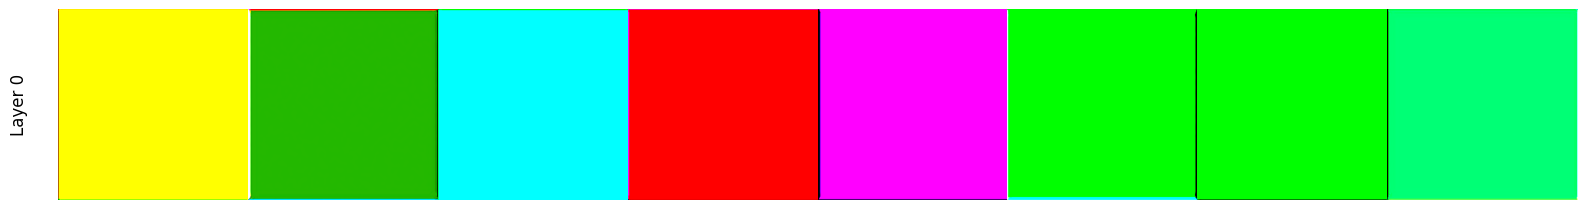

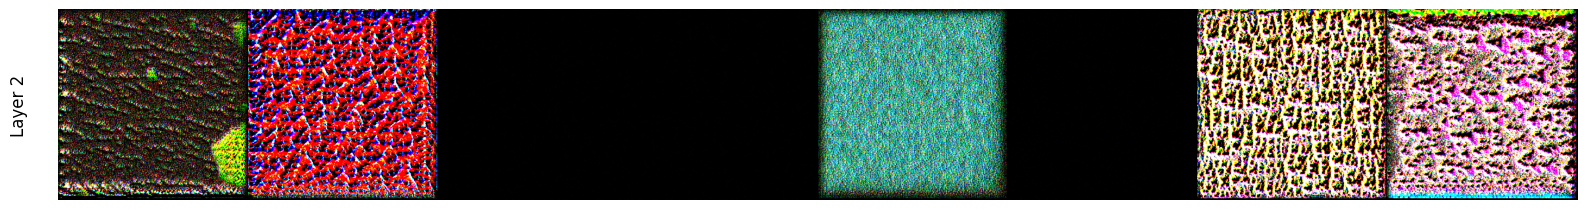

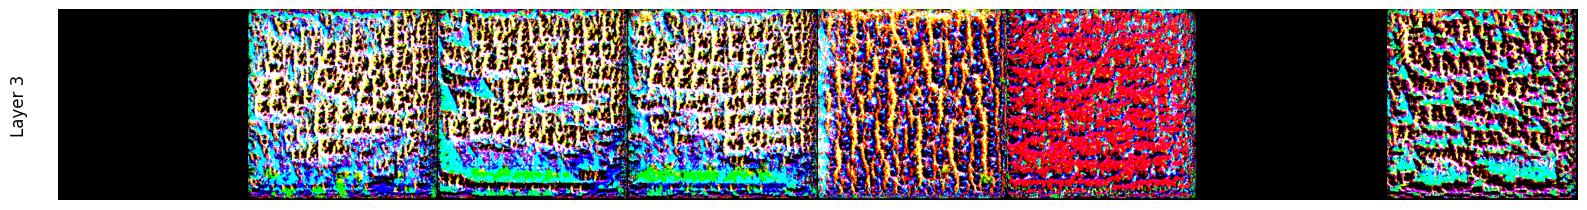

In [30]:
visualizer = FilterVisualizer(model=cat_model, size=64, upscaling_steps=10, upscaling_factor=1.2, device=device)
visualizer.visualize_filters(conv_layer_index=0, filters=[0,2,5,10,14,16,17,19])
visualizer.visualize_filters(conv_layer_index=2, filters=[11,13,17,20,23,27,36,39])
visualizer.visualize_filters(conv_layer_index=3, filters=[0,1,3,5,10,13,16,17])

### 6.4. Visualizing class activation

- 模型的可解释性-XAI
- We can also visualize which pixels of the input had the greatest influence on the final classification. Helps to interpret what the model is paying attention t0.

**类激活图(Class Activation Maps):** 在输入图像上生成热图(heatmap):

- 选择一个卷积层, 进行全局平均池化(GAP), 每个通道( or feature map )获得一个输出

- 获取这些输出与目标类别之间的权重

- 计算所有滤波器激活值的加权和: 结合每个滤波器的响应以及这些响应对类别预测的影响程度

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/activation_map.png?raw=1" alt="ml" style="width: 50%;  margin-left: auto; margin-right: auto;"/>

In [33]:
def gradCAM(img_path, model, input_size = (150,150), layer_idx=-1, show_channels=True, top_k=8):
    model = model
    model.eval()
    target_layer = model.conv_layers[layer_idx] if hasattr(model, "conv_layers") else model[layer_idx]
    #target_layer = model.layer4[-1]

    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    original_img = cv2.imread(img_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    display_img = original_img.copy()
    img_tensor = preprocess(original_img).unsqueeze(0)

    activations = None
    gradients = None

    def forward_hook(module, input, output):
        nonlocal activations
        activations = output

    def backward_hook(module, grad_input, grad_output):
        nonlocal gradients
        gradients = grad_output[0]

    target_layer.register_forward_hook(forward_hook)
    target_layer.register_full_backward_hook(backward_hook)

    output = model(img_tensor)
    pred_class = output.argmax(dim=1).item()
    model.zero_grad()
    output[:, pred_class].backward()

    weights = torch.mean(gradients, dim=[2, 3], keepdim=True)  # [B, C, 1, 1]
    activations = activations.detach().squeeze(0)              # [C, H, W]
    weights = weights.detach().squeeze(0).squeeze(-1).squeeze(-1)  # [C]

    # Visualize top-k channels
    if show_channels:
        # Get top-k channel indices by absolute weight
        _, top_idxs = torch.topk(weights.abs(), k=top_k)
        fig, axes = plt.subplots(1, top_k, figsize=(2.5 * top_k, 2.5))
        for i, idx in enumerate(top_idxs):
            channel_img = activations[idx].cpu().numpy()
            channel_img = np.maximum(channel_img, 0)
            channel_img /= channel_img.max() + 1e-10
            channel_img = cv2.resize(channel_img, (original_img.shape[1], original_img.shape[0]))

            weighted_img = channel_img * weights[idx].item()
            weighted_img = np.clip(weighted_img, 0, 1)

            axes[i].imshow(channel_img, cmap='viridis')
            axes[i].axis('off')
            axes[i].set_title(f"w={weights[idx].item():.4f}", fontsize=12)

            #axes[1, i].imshow(weighted_img, cmap='inferno')
            #axes[1, i].axis('off')
            #axes[1, i].set_title(f"w × ch {idx.item()}", fontsize=12)

        plt.suptitle("Top Conv Channels & Weights", fontsize=14)
        plt.tight_layout()
        plt.show()

    # Final Grad-CAM map
    heatmap = torch.sum(weights[:, None, None] * activations, dim=0).cpu().numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= heatmap.max() + 1e-10
    heatmap_resized = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap_colored, 0.4, 0)

    # Show original + Grad-CAM
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(display_img)
    axs[0].axis("off")
    axs[0].set_title("Original Image", fontsize=12)

    axs[1].imshow(superimposed_img)
    axs[1].axis("off")
    axs[1].set_title("Grad-CAM", fontsize=12)

    plt.tight_layout()
    plt.show()

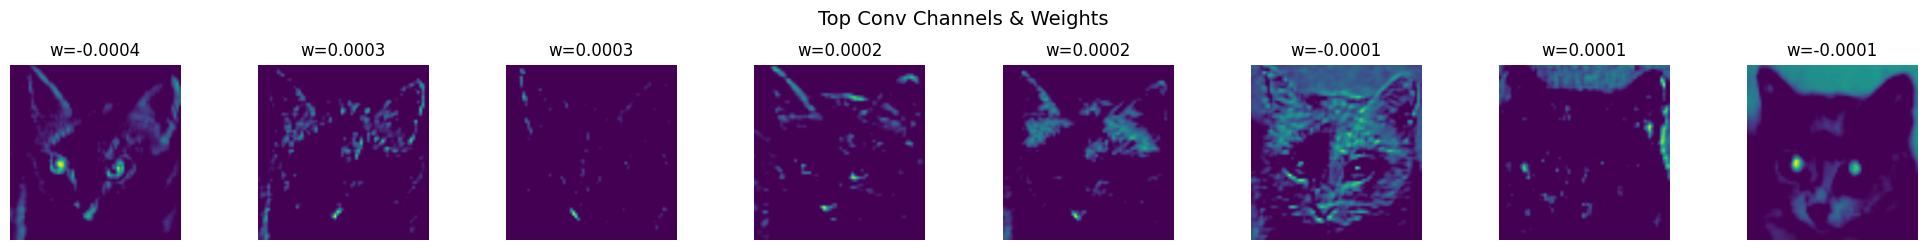

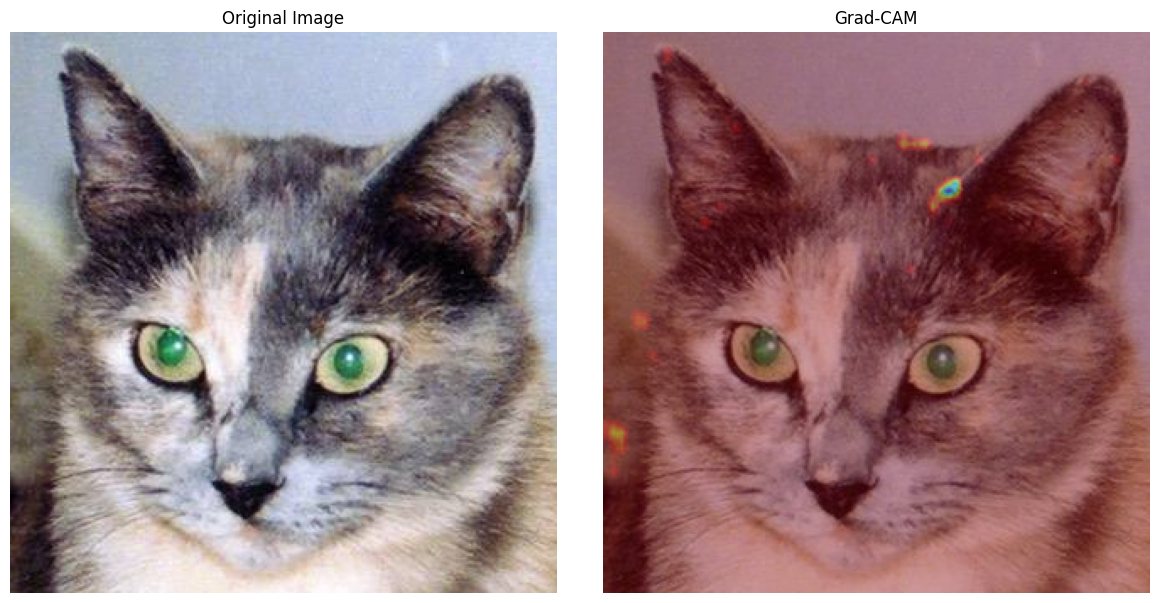

In [ ]:
# img_tensor_dog = load_image(img_path_dog).to(device)
gradCAM(img_path, model, input_size = (150,150), layer_idx=3, show_channels=True, top_k=8)